# Activity Investigation

This should be helpful when I just want to look closely at the results of a particular activity stream

In [ ]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities, get_clean_stream
from strava.data.cache import Cache

from strava.data.segment_access import (
    request_segment,
    create_segment_catalog, 
    segment_id_from_activity_date_and_index, 
    effort_link_to_segment_id, 
    segment_link_to_segment_id
)
from strava.data.Segment import Segment
from strava.plotting.segment_plots import segment_effort_graph

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()
pt.light()

pd.set_option('display.max_columns', 500)


%load_ext autoreload
%autoreload 2

In [2]:
# Create a cache
stream_cache = Cache()
activity_cache = Cache(dir='/Users/lucasnieuwenhout/Documents/Programming/Python/Projects/StravaPlotting/activity_cache/')

In [3]:
# Get a list of activities
activities = get_clean_activities()
activities.tail()

Existing access token is valid.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 200 activities.
-> Received page 4 with 74 activities.
-> Received page 5 with 0 activities.
...retrieved total of 674 activities.


/Users/lucasnieuwenhout/Documents/Programming/Python/Projects/StravaPlotting/src/generate_plots.py:150: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
668,3425015993,Afternoon Ride,8964.6,0 days 00:26:43,0 days 00:26:43,39.0,693.8,654.7,Ride,2020-04-26 15:07:20,(GMT-07:00) America/Edmonton,"[53.636688, -113.587822]","[53.636729, -113.587903]",0,a3425015993,10.0,20.1312,40.32,165.0,185.0,{mjfIhhjtTt@fAf@|@HREZUpAe@pB{@vC]z@a@r@k@x@c@...,2020,1970-04-26 15:07:20
669,3425016238,Lunch Ride,17516.8,0 days 00:48:11,0 days 00:48:11,71.2,693.8,653.7,Ride,2020-04-25 11:48:43,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,21.8124,50.04,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...,2020,1970-04-25 11:48:43
670,3425017204,Afternoon Ride,14517.0,0 days 00:47:28,0 days 00:47:28,64.1,693.8,653.7,Ride,2020-04-23 13:02:13,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,18.3492,36.72,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...,2020,1970-04-23 13:02:13
671,3425016478,Afternoon Ride,17605.8,0 days 00:57:41,0 days 00:57:41,69.9,693.8,653.7,Ride,2020-04-22 14:48:16,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,18.3132,39.96,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...,2020,1970-04-22 14:48:16
673,3425016348,Afternoon Ride,7278.0,0 days 00:23:28,0 days 00:23:28,21.9,693.8,684.9,Ride,2020-04-16 13:57:58,(GMT-07:00) America/Edmonton,"[53.636894, -113.587782]","[53.636646, -113.587864]",0,a3425016348,10.0,18.6084,36.00,177.8,197.0,uojfIxhjtTvB|CjAnBbApBlA|CXdC^tEL`CB|ACtBKjBs@...,2020,1970-04-16 13:57:58


# Explore Segment API
- This is quite interesting...
- I can't use the segment effort api, but I can use the segment detail one.  This holds the kom and local legend details.


- Would be good to pull this information for each segment.  Compare against my best efforts.
- Can plot average time per month or season or something, or best time per month/season.
  - Could potentially plot the heartrate for the best effort?  Or the maximum speed?

In [6]:
segment_effort_url = "https://www.strava.com/api/v3/segments/"

In [8]:
r = request_segment(31582444)

Existing access token is valid.
Received 1827 bytes.


In [9]:
json.loads(r.content)

{'id': 31582444,
 'resource_state': 3,
 'name': '28th - it says bike route....',
 'activity_type': 'Ride',
 'distance': 734.2,
 'average_grade': 2.0,
 'maximum_grade': 5.1,
 'elevation_high': 75.2,
 'elevation_low': 58.6,
 'start_latlng': [49.052882, -122.78008],
 'end_latlng': [49.052823, -122.790121],
 'elevation_profile': 'https://d3o5xota0a1fcr.cloudfront.net/v6/charts/BRLSPYSPS7J4TCZ3QJO3W62FBPDAQRLHHAVJ4KOLRZDFLOBZOLWP5ZNDURNWZHIIESTCAFPJ5YKOLFLK5ZF3FIOO',
 'elevation_profiles': {'light_url': 'https://d3o5xota0a1fcr.cloudfront.net/v6/charts/BRLSPYSPS7J4TCZ3QJO3W62FBPDAQRLHHAVJ4KOLRZDFLOBZOLWP5ZNDURNWZHIIESTCAFPJ5YKOLFLK5ZF3FIOO',
  'dark_url': 'https://d3o5xota0a1fcr.cloudfront.net/v6/charts/SE4BUDO3W6BSEJDS43J4YZB3TTI7BEN5FJ7IFWPEWDQDFOE7TX4G2RFSCRFJU6OJZCTWRM2CXW6AXMTDT4P6XJDS'},
 'climb_category': 0,
 'city': 'Surrey',
 'state': 'British Columbia',
 'country': 'Canada',
 'private': False,
 'hazardous': False,
 'starred': False,
 'created_at': '2022-04-24T20:34:56Z',
 'updated_

## Segments in BC

In [11]:
# Find the BC activities by filtering to rides below latitude of 50
bc_activities = activities[activities.start_latlng.apply(lambda x: float(x[0])) < 50]
segment_ids = set()
segments = {}
for act_id in bc_activities.id:
    ad = get_activity_detail(activities, act_id, activity_cache, include_all_efforts=True)
    for effort in ad['segment_efforts']:
        
        # If the segment is not already in the list, add it
        if effort['segment']['id'] not in segments:
            segments[effort['segment']['id']] = Segment(id=effort['segment']['id'])

        # Add the effort to the segment
        segments[effort['segment']['id']].add_effort(effort)

# Print out the segment ids and names
segment_id_lookup = {}
for k, v in segments.items():
    print(f"{k}: {v.efforts[0].segment_name}: {v}")
    segment_id_lookup[k] = v.efforts[0].segment_name

28263054: Light Up 164A: Segment: 28263054, 84 efforts
39799094: 164a St Crit: Segment: 39799094, 67 efforts
10815093: Morgan 164A Crit: Segment: 10815093, 73 efforts
32287650: Greenbelt Hook: Segment: 32287650, 9 efforts
23390260: Rosemary Heights Climb: Segment: 23390260, 1 efforts
21639209: Devonshire Drive Up: Segment: 21639209, 1 efforts
11599211: 164A St Crits REV - Counter Steer: Segment: 11599211, 7 efforts
28320609: Morgan Creek Crescent Crit Course: Segment: 28320609, 1 efforts
35811651: Devonshire Dash: Segment: 35811651, 1 efforts
31582444: 28th - it says bike route....: Segment: 31582444, 79 efforts
25667954: KG to 20 on 156: Segment: 25667954, 87 efforts
10267456: It smells richer in White Rock: Segment: 10267456, 87 efforts
20245971: The Leafs Blow: Segment: 20245971, 82 efforts
1145071: Marine Drive Rollers: Segment: 1145071, 87 efforts
3935337: white rockin': Segment: 3935337, 87 efforts
19129655: Cruisin' East Beach - Westbound: Segment: 19129655, 86 efforts
16233163:

In [12]:
# Testing
segments[36494958].effort_df

,EffortID,SegmentID,ActivityID,SegmentName,ElapsedTime[s],MovingTime[s],StartDateLocal,AverageHR,MaxHR,PRRank,DateTime,DateTimeIndex,ActivityIndex
0,3204550702634615646,36494958,8922073333,Sing for your Supper,94,94,2023-04-19T16:24:01Z,157.1,167.0,NaN,2023-04-19 16:24:01+00:00,1,0
1,3204550469676731714,36494958,8958041352,Sing for your Supper,83,83,2023-04-25T19:19:30Z,170.9,177.0,NaN,2023-04-25 19:19:30+00:00,2,1
2,3204550473457083714,36494958,8969734450,Sing for your Supper,83,83,2023-04-27T18:35:05Z,177.2,180.0,NaN,2023-04-27 18:35:05+00:00,3,2
3,3204550358788239198,36494958,9185773882,Sing for your Supper,84,84,2023-06-01T19:31:06Z,152.5,159.0,NaN,2023-06-01 19:31:06+00:00,4,3
4,3204550323862407490,36494958,9217383468,Sing for your Supper,85,85,2023-06-06T18:47:09Z,163.7,172.0,NaN,2023-06-06 18:47:09+00:00,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,3354257871156269440,36494958,14380337660,Sing for your Supper,75,75,2025-05-04T16:34:26Z,169.3,174.0,NaN,2025-05-04 16:34:26+00:00,74,73
74,3355364215427946232,36494958,14411086862,Sing for your Supper,87,87,2025-05-07T17:53:51Z,140.9,151.0,NaN,2025-05-07 17:53:51+00:00,75,74
75,3356763432739999528,36494958,14450984650,Sing for your Supper,96,95,2025-05-11T14:31:20Z,159.0,169.0,NaN,2025-05-11 14:31:20+00:00,76,75
76,3357185481395896202,36494958,14462174065,Sing for your Supper,80,80,2025-05-12T18:01:28Z,163.6,170.0,NaN,2025-05-12 18:01:28+00:00,77,76


Very cool...

Would also be very cool to basically just use Strava's interface to explore segments and then be able to pull up the stats here by pasting the link or something.

Can make a view to see the last 15 or whatever efforts.

You can also request the segment, or segment effort streams, if that is helpful at all, might be neat for something like an effort check.

Create some premade filters like segments with large elevation change, or long ones, or short ones.

Activity Link: https://www.strava.com/activities/14307309734

Activity Segment Effort Link: https://www.strava.com/activities/14307309734/segments/3351715314413497486

Segment Link: https://www.strava.com/segments/14958585

https://strava.app.link/896fISkRWSb

# Segment Effort Graph

## Processing

In [4]:
# Find the BC activities by filtering to rides below latitude of 50
bc_activities = activities[activities.start_latlng.apply(lambda x: float(x[0])) < 50]
# Create the catalog of segments
bc_segments = create_segment_catalog(activities, activity_list=bc_activities, activity_cache=activity_cache)

# Print the segment ids and names
segment_id_lookup = {}
for k, v in bc_segments.items():
    print(f"{v}: {v.efforts[0].segment_name}")
    segment_id_lookup[k] = v.efforts[0].segment_name

Segment: 28263054, 84 efforts: Light Up 164A
Segment: 39799094, 67 efforts: 164a St Crit
Segment: 10815093, 73 efforts: Morgan 164A Crit
Segment: 32287650, 9 efforts: Greenbelt Hook
Segment: 23390260, 1 efforts: Rosemary Heights Climb
Segment: 21639209, 1 efforts: Devonshire Drive Up
Segment: 11599211, 7 efforts: 164A St Crits REV - Counter Steer
Segment: 28320609, 1 efforts: Morgan Creek Crescent Crit Course
Segment: 35811651, 1 efforts: Devonshire Dash
Segment: 31582444, 79 efforts: 28th - it says bike route....
Segment: 25667954, 87 efforts: KG to 20 on 156
Segment: 10267456, 87 efforts: It smells richer in White Rock
Segment: 20245971, 82 efforts: The Leafs Blow
Segment: 1145071, 87 efforts: Marine Drive Rollers
Segment: 3935337, 87 efforts: white rockin'
Segment: 19129655, 86 efforts: Cruisin' East Beach - Westbound
Segment: 16233163, 87 efforts: marine kicker
Segment: 19059308, 87 efforts: Rollin' Restaurant Row
Segment: 19628715, 88 efforts: Hotties & Hot Rods
Segment: 23981846,

## Plotting

#### Plot based on activity

https://www.strava.com/segments/31582444


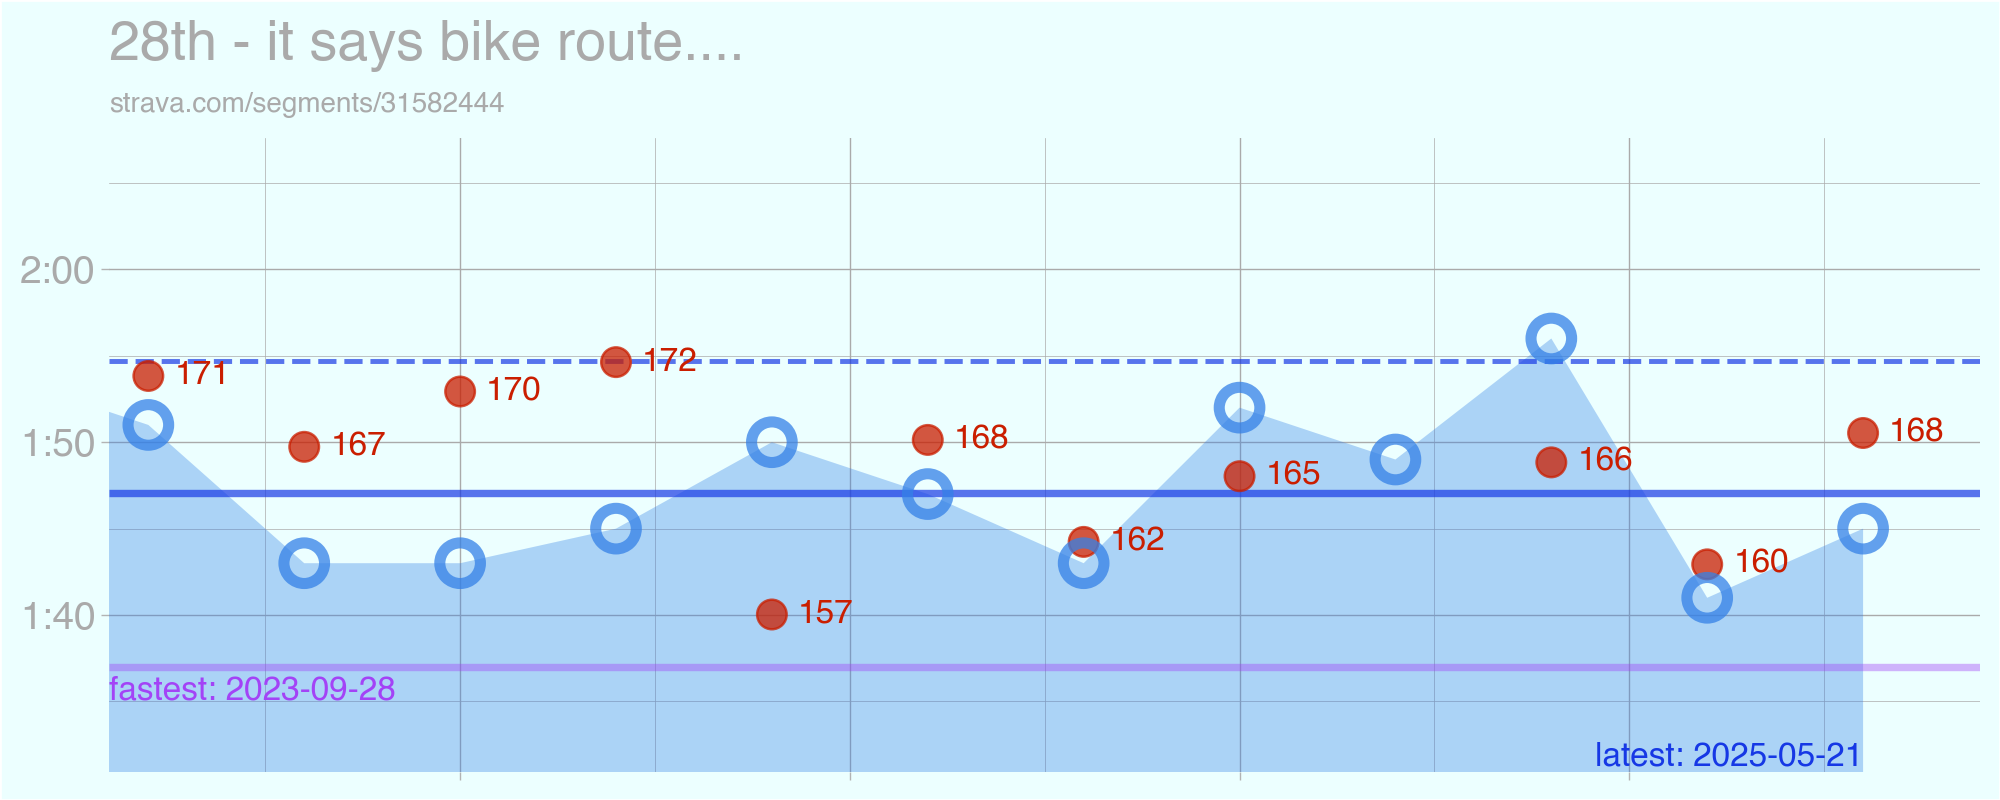

In [5]:
# Selection of segment
activity_date = datetime.date(2025, 5, 7)
segment_index = 0
# activity_date = datetime.date(2025, 7, 31)
# segment_index = 0
segment_id = segment_id_from_activity_date_and_index(activities, activity_cache, activity_date, segment_index)

# Do them all
# for i in range(50):
#     print(i)
#     segment_id = segment_id_from_activity_date_and_index(activities, activity_date, i)
#     segment_effort_graph(bc_segments, segment_id, previous_x=12, save_plot=True)

# Plot
plot, link = segment_effort_graph(bc_segments, segment_id, previous_x=12)
print(link)
plot

#### Plot based on segment link
This is the link available on the dedicated segment page

https://www.strava.com/segments/23981846


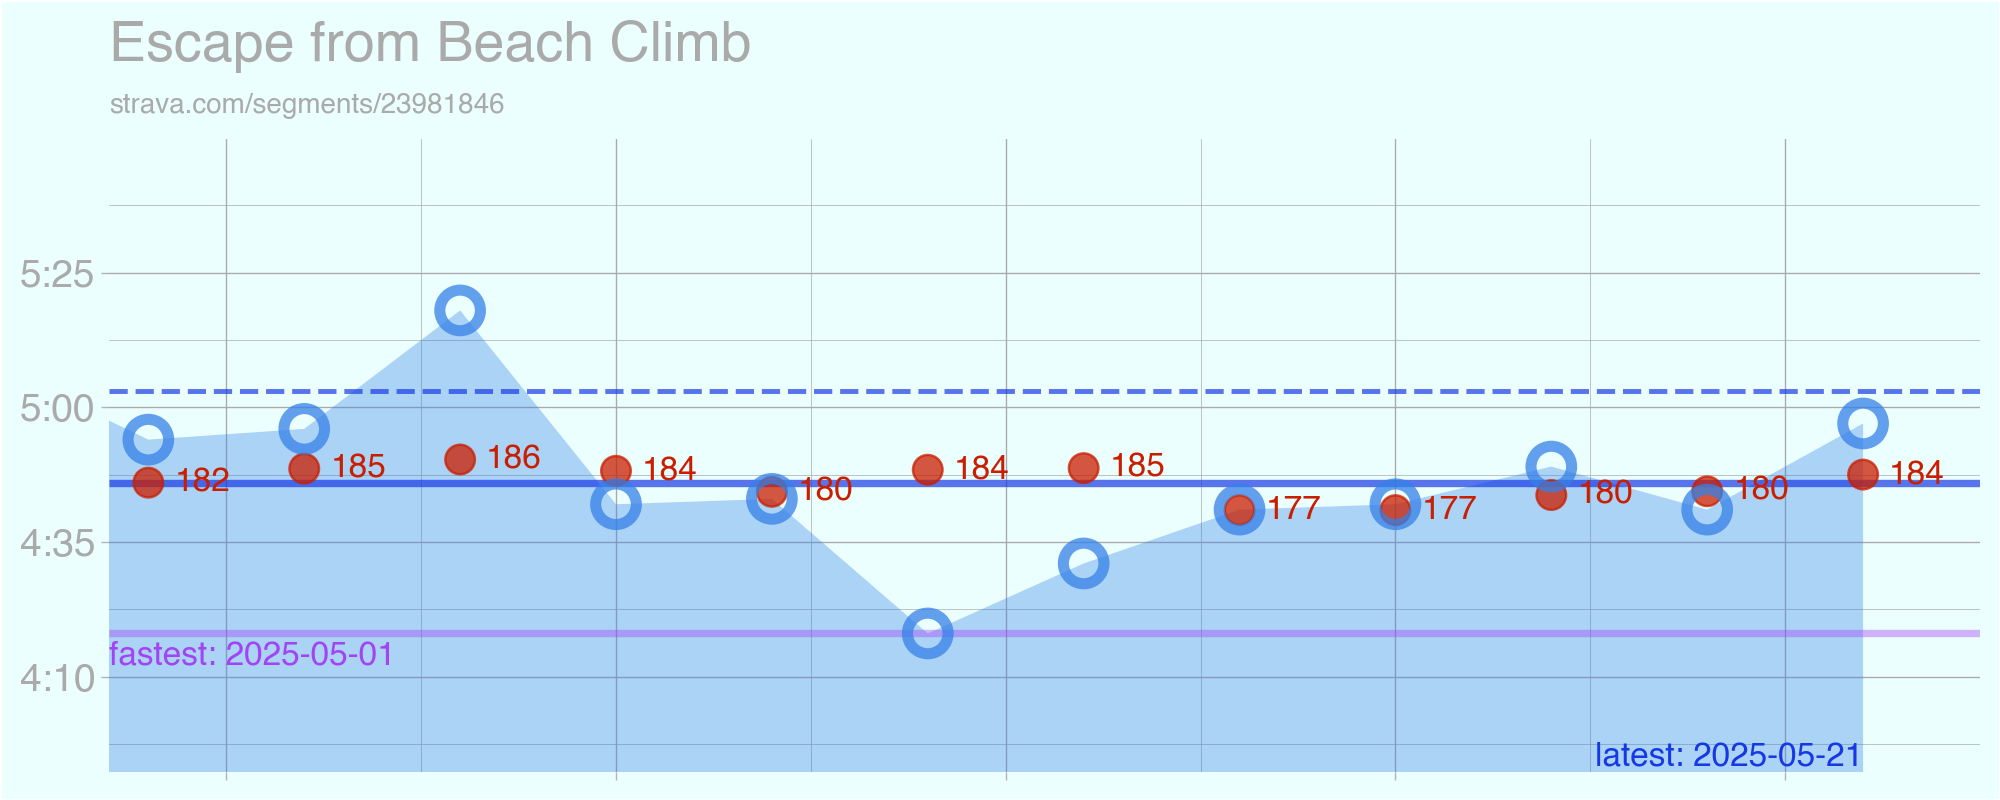

In [20]:
# Selection of segment
segment_id = segment_link_to_segment_id('https://www.strava.com/segments/23981846?filter=overall')

# Plot
plot, link = segment_effort_graph(bc_segments, segment_id, previous_x=12)
print(link)
plot

#### Plot based on segment effort link
This is the link available from the activity view

14556255631
https://www.strava.com/segments/16233163


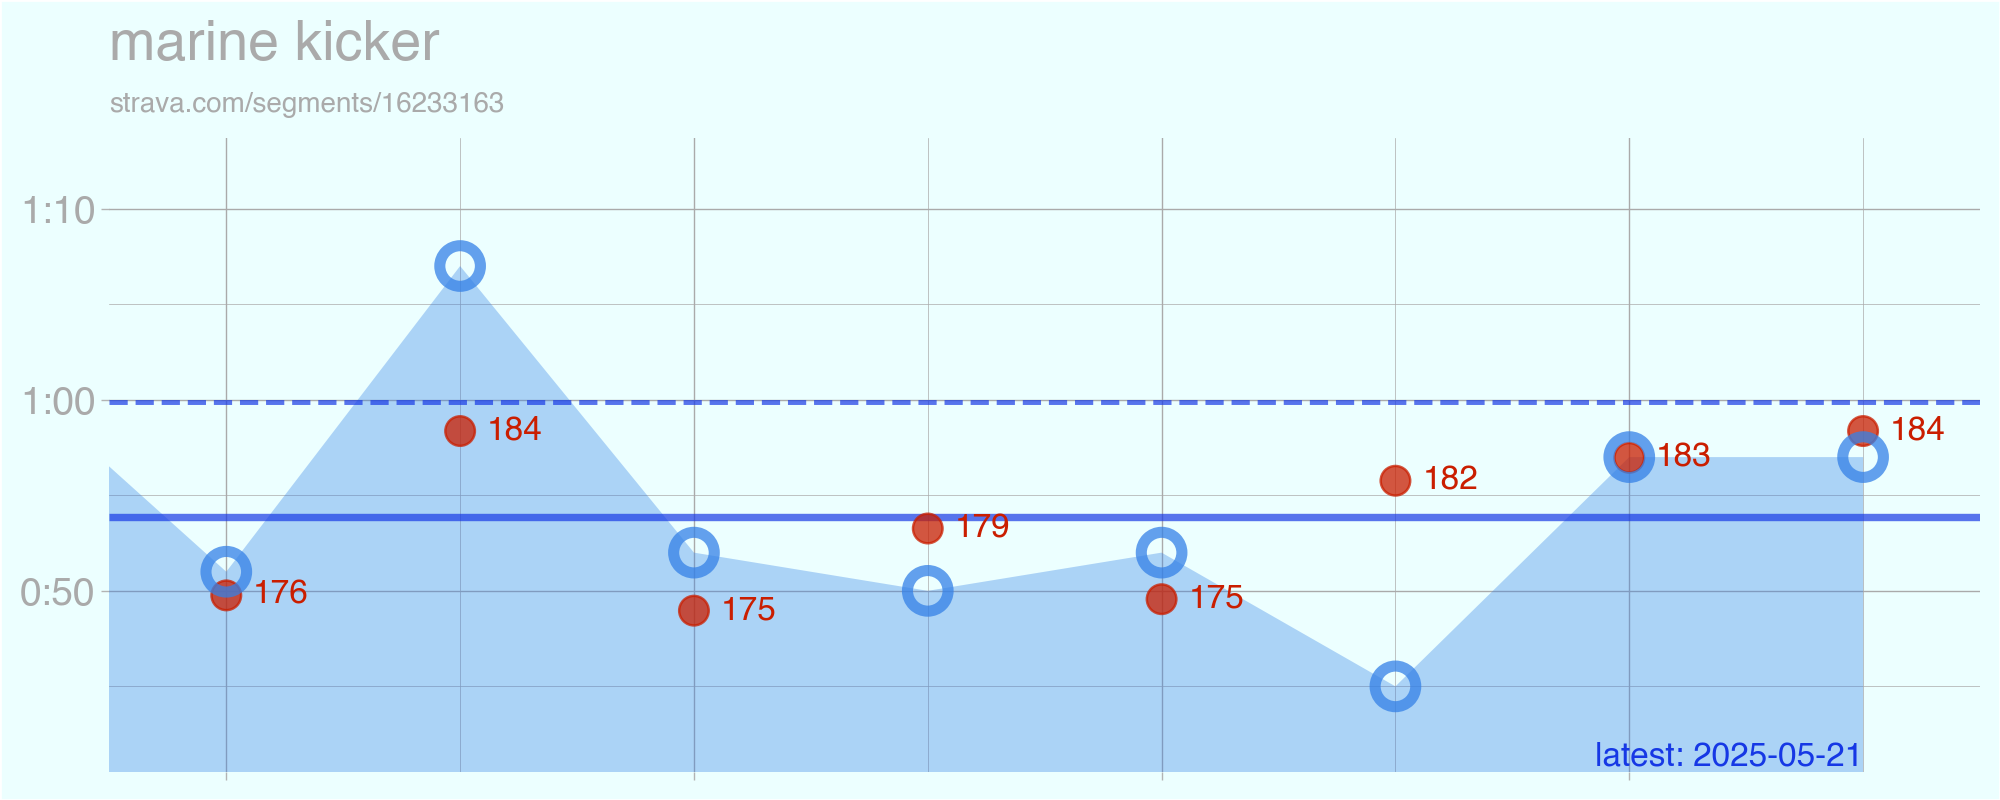

In [21]:
# Selection of segment
segment_effort_link = 'https://www.strava.com/activities/14556255631/segments/3360435161775305032'
segment_id = effort_link_to_segment_id(activities=activities, 
                          activity_cache=activity_cache, 
                          link=segment_effort_link)

# Plot
plot, link = segment_effort_graph(bc_segments, segment_id)
print(link)
plot

14556255631
https://www.strava.com/segments/1808269


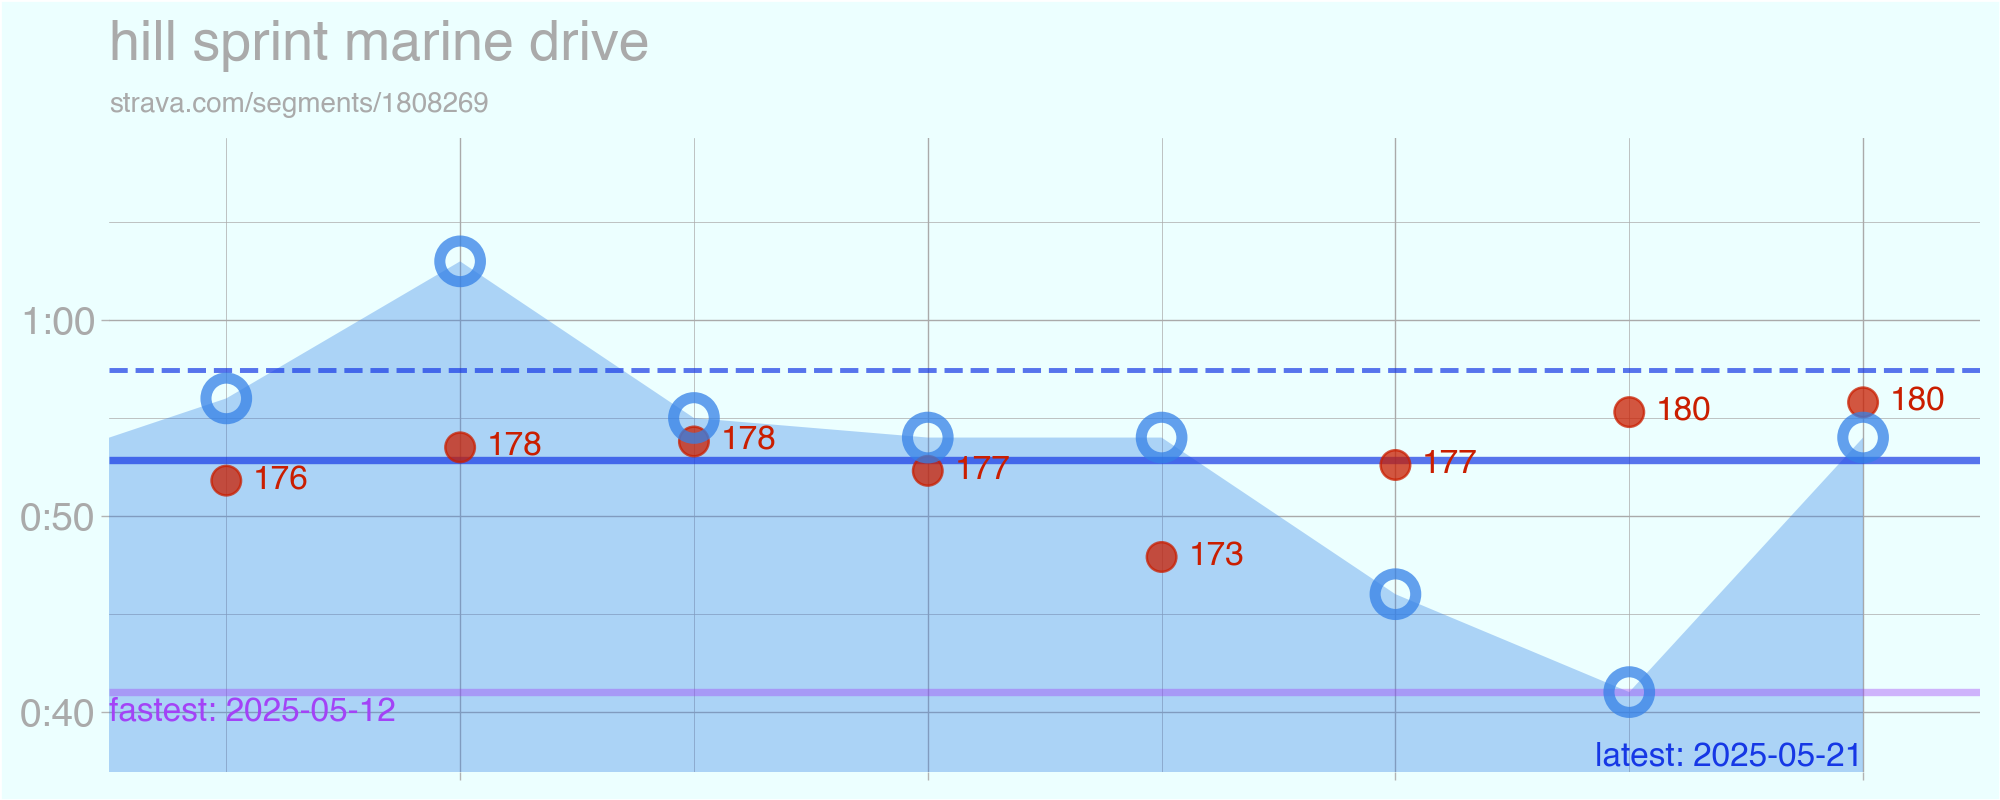

In [22]:
# Selection of segment
segment_effort_link = 'https://www.strava.com/activities/14556255631/segments/3360435161774649672'
segment_id = effort_link_to_segment_id(activities=activities, 
                          activity_cache=activity_cache, 
                          link=segment_effort_link)

# Plot
plot, link = segment_effort_graph(bc_segments, segment_id)
print(link)
plot

14556255631
https://www.strava.com/segments/1474224


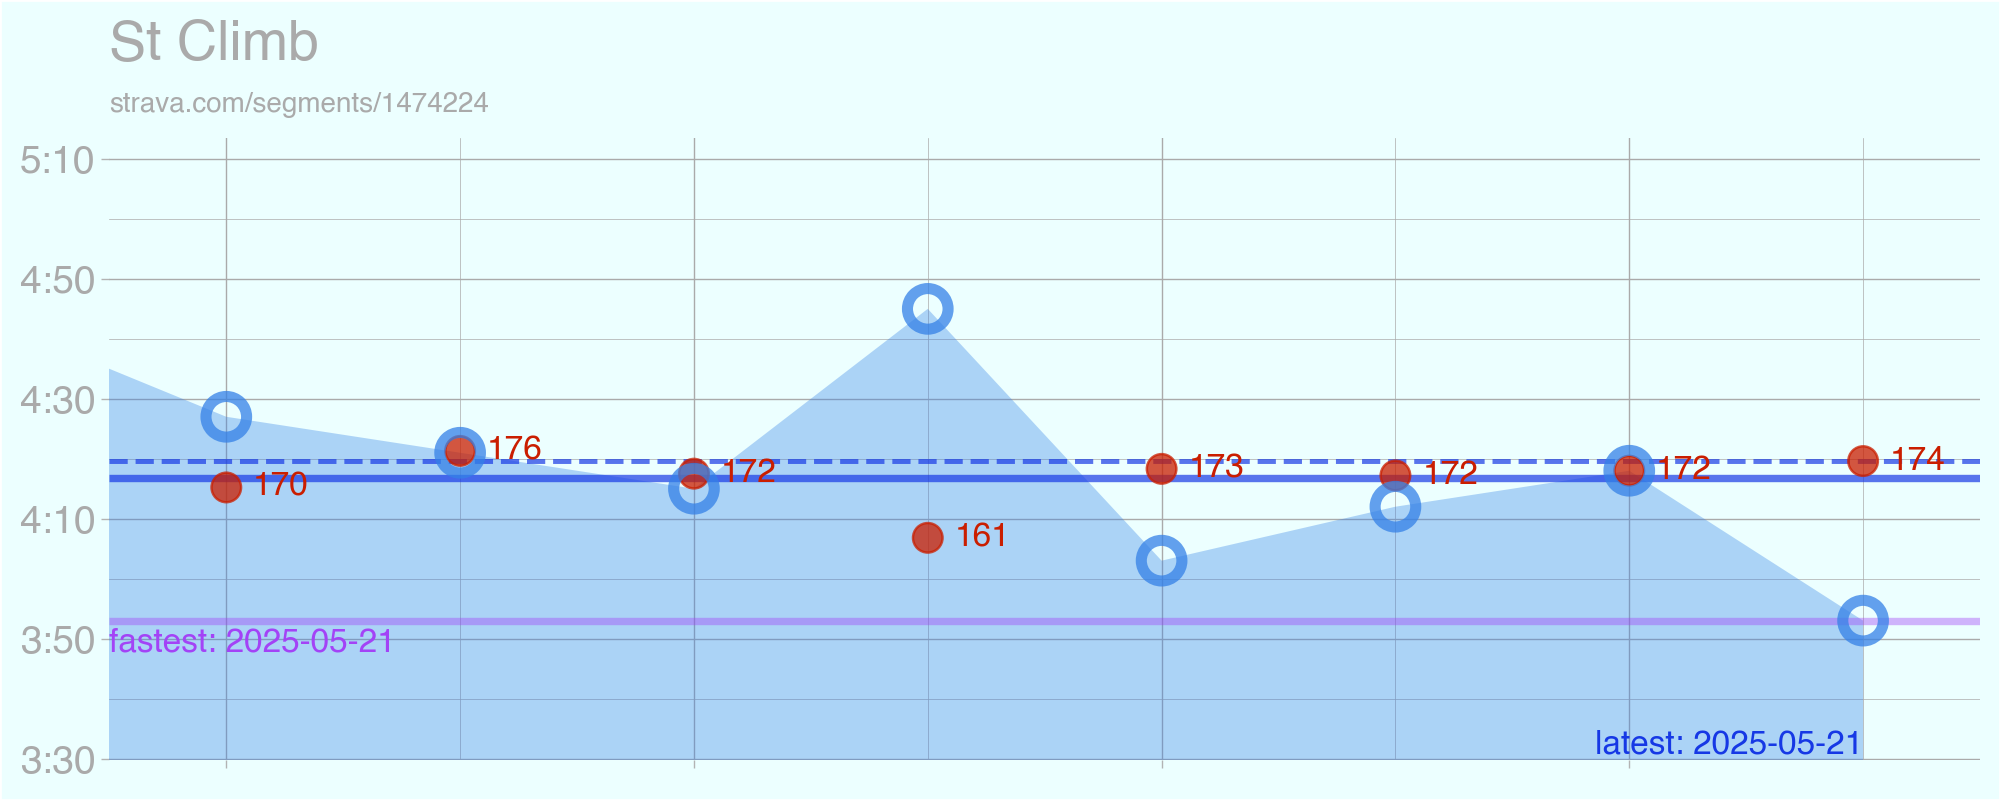

In [23]:
# Selection of segment
segment_effort_link = 'https://www.strava.com/activities/14556255631/segments/3360435161776204104'
segment_id = effort_link_to_segment_id(activities=activities, 
                          activity_cache=activity_cache, 
                          link=segment_effort_link)

# Plot
plot, link = segment_effort_graph(bc_segments, segment_id)
print(link)
plot

15664199370
https://www.strava.com/segments/39799094


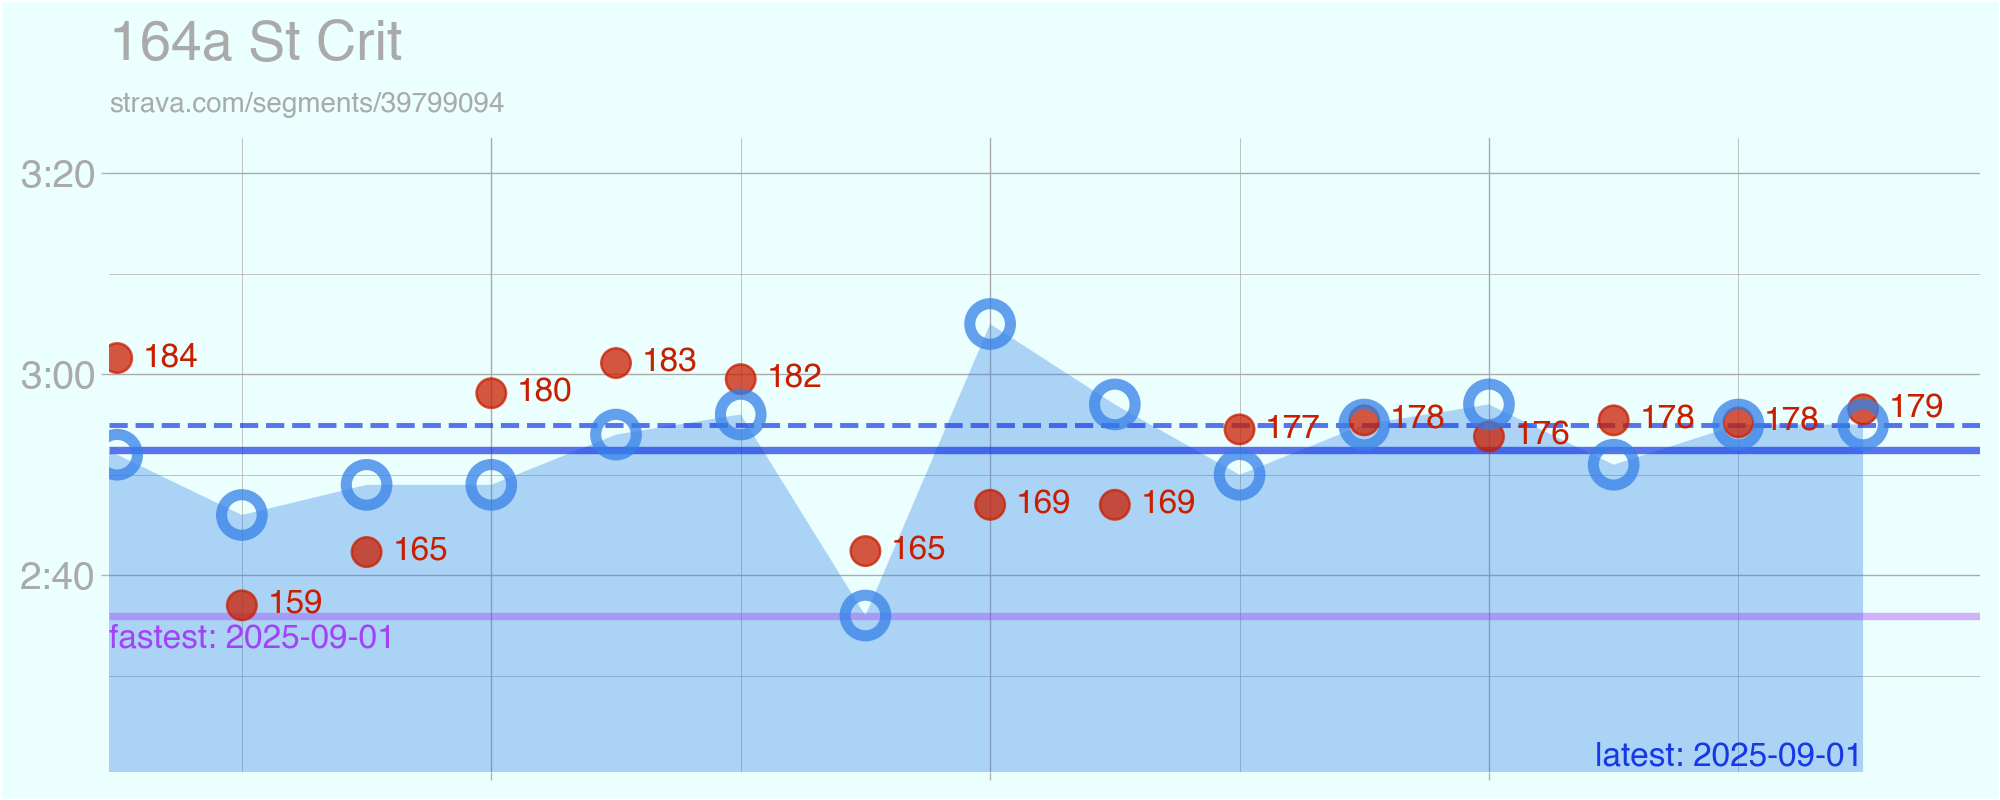

In [25]:
# Selection of segment
segment_effort_link = 'https://www.strava.com/activities/15664199370/segments/3397706930100418250'
segment_id = effort_link_to_segment_id(activities=activities, 
                          activity_cache=activity_cache, 
                          link=segment_effort_link)

# Plot
plot, link = segment_effort_graph(bc_segments, segment_id, previous_x=15)
print(link)
plot

In [ ]:
# Would be neat to average out the times on a weekly or monthly basis to see if they're trending up/down.

# Would also be neat to add in some details about the segment.  Elevation, distance, grade, KOM time, Local legend count, if I hold any of them, or if I'm top 10, ...

# Would also be neat to see for each ride how many were above/below average for their segment.

# Would be neat to see a distribution of the effort times.

# Would be neat to see a top 10 of effort times.

# Below is true experimentation - Mostly segment effort duration density

In [28]:
def segment_effort_graph_distribution(segment_catalog: pd.DataFrame, segment_id: int, previous_x: int=8, save_plot: bool=False):
    """Generaet recent segment effort graph from the segment id.

    Args:
        segment_catalog (pd.DataFrame): Catalog of segments
        segment_id (int): _description_
        previous_x (int, optional): _description_. Defaults to 8.
        save_plot (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """

    # Check inputs
    if previous_x < 3:
        print(f"Must plot at least three points")
        return (None, None)

    # Generate the segment link
    segment_link = f'https://www.strava.com/segments/{segment_id}'
    
    # Create the dataframe of segment efforts
    segment = segment_catalog[segment_id]
    plot_df = segment.effort_df()
    plot_df_prev = plot_df[plot_df.DateTimeIndex > (plot_df.DateTimeIndex.max() - previous_x)].copy()

    # Filtering and Such?
    # - Filter to only a single effort per activity.  Have to reset the index on the activity, or I could base the index off of time instead of activity ID.

    # Segment Information
    segment_name = plot_df.SegmentName[0]

    # Colours
    ribbon_colour = '#3481E7'
    averages_colour = '#1638E5'
    hr_colour = '#CA1E00'
    pr_colour = '#A343F6'
    # pr_colour = '#1A4F1B'
    # pr_colour = '#5FE4E7'
    # hr_colour = '#E74F59'

    # --- X ---
    # Full Range
    xmin = 0
    # Limit min to previous_x
    xmin = plot_df['MovingTime[s]'].min()
    # Full Range
    xmax = plot_df['MovingTime[s]'].max()

    xlim = (xmin, xmax)

    # --- Y ---
    ymin = 0
    # Full Range
    ymin = plot_df['MovingTime[s]'].min() * 0.9
    ymax = plot_df['MovingTime[s]'].max() * 1.1
    # Prevous x
    ymin = plot_df_prev['MovingTime[s]'].min() * 0.9
    ymax = plot_df_prev['MovingTime[s]'].max() * 1.1

    ylim = (ymin, ymax)

    # --- Ribbon ---
    plot_df['xmin'] = xmin
    plot_df['xmax'] = xmax
    plot_df['ymin'] = ymin
    plot_df['ymax'] = ymax

    # --- Labels ---
    plot_df_prev['AverageHRLabel'] = plot_df_prev.AverageHR.apply(lambda x: round(x))

    # --- Averages ---
    alltime_avg = plot_df['MovingTime[s]'].mean()
    window_avg = plot_df_prev['MovingTime[s]'].mean()

    # --- Heartrate Points ---
    plot_df_prev['AverageHRPlot'] = plot_df_prev.AverageHR + plot_df_prev['MovingTime[s]'].mean() - plot_df_prev.AverageHR.mean()

    # --- PR ---
    pr_effort, pr_time = segment.pr()
    pr_label_df = pd.DataFrame({'x': [xmin], 'y': [pr_time - (pr_time / 200)], 'label': [f"{pr_effort.start_date_local.split('T')[0]}"]})
    print(plot_df)

    # --- Colour by Year ---
    plot_df['year'] = plot_df.DateTime.apply(lambda x: x.year)

    # --- Plot ---
    g = (gg.ggplot()
        # + gg.geom_ribbon(plot_df, gg.aes(x='DateTimeIndex', ymin='ymin', ymax='MovingTime[s]'), fill=ribbon_colour, alpha=0.35)
        # + gg.geom_histogram(plot_df, gg.aes(x='MovingTime[s]'), binwidth=1, fill=ribbon_colour, colour=averages_colour)
        + gg.geom_density(plot_df, gg.aes(x='MovingTime[s]', fill='factor(year)'), colour=averages_colour, adjust=0.5, alpha=0.7)

        # + gg.geom_hline(plot_df, gg.aes(yintercept=alltime_avg), size=1, colour=averages_colour, alpha=0.7, linetype='dashed')
        # + gg.geom_hline(plot_df, gg.aes(yintercept=window_avg), size=1.5, colour=averages_colour, alpha=0.7)

        # + gg.geom_hline(plot_df, gg.aes(yintercept=pr_time), size=1.5, colour=pr_colour, alpha=0.4)
        # + gg.geom_text(pr_label_df, gg.aes(x='x', y='y', label='label'), colour=pr_colour, ha='left', va='top', size=12)

        # + gg.geom_point(plot_df_prev, gg.aes(x='DateTimeIndex', y='AverageHRPlot'), size=5.5, alpha=0.75, colour=hr_colour)
        # + gg.geom_point(plot_df, gg.aes(x='DateTimeIndex', y='MovingTime[s]'), size=6, alpha=0.75, stroke=2.25, colour=ribbon_colour, fill="none")

        # + gg.geom_text(plot_df_prev, gg.aes(x=f'DateTimeIndex + {0.010 + previous_x * 0.028}', y='AverageHRPlot', label='AverageHRLabel'), colour=hr_colour, size=12)

        + gg.coord_cartesian(xlim=xlim, expand=False)

        # + gg.scale_y_continuous(labels=lambda y: [f"{x // 60:0.0f}:{x % 60:02.0f}" for x in y])

        + pt.gg_theme()
        + gg.theme(
                # figure_size=(14, 6),
                figure_size=(10, 4),
                panel_border=gg.element_blank(),
                axis_text=gg.element_text(size=18),
                axis_title=gg.element_text(size=24),
                axis_text_x=gg.element_text(size=14),
                axis_text_y=gg.element_blank(),
                plot_title=gg.element_text(size=20, ha='left'),
                )
        + gg.labs(x="", y="", title=segment_name,)
    )

    if save_plot:
        g.save(filename=segment_plot_path + f"{segment_id}.png")

    return (g, segment_link)

               EffortID  SegmentID   ActivityID  \
0   3101343120490517670   19129655   9217383468   
1   3102069792278362236   19129655   9230073044   
2   3103126304213611520   19129655   9248733657   
3   3103126304209605632   19129655   9248733657   
4   3104242475649390432   19129655   9267803475   
..                  ...        ...          ...   
78  3351715314416546958   19129655  14307309734   
79  3353206872243148786   19129655  14350214386   
80  3353899417891225586   19129655  14369761755   
81  3354257871156302208   19129655  14380337660   
82  3355364215429790456   19129655  14411086862   

                        SegmentName  ElapsedTime[s]  MovingTime[s]  \
0   Cruisin' East Beach - Westbound              63             63   
1   Cruisin' East Beach - Westbound              73             68   
2   Cruisin' East Beach - Westbound              49             49   
3   Cruisin' East Beach - Westbound              63             63   
4   Cruisin' East Beach - Westbound  

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/stat_density.py:152: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/stat_density.py:155: PlotnineWarning: Groups with fewer than 2 data points have been removed.


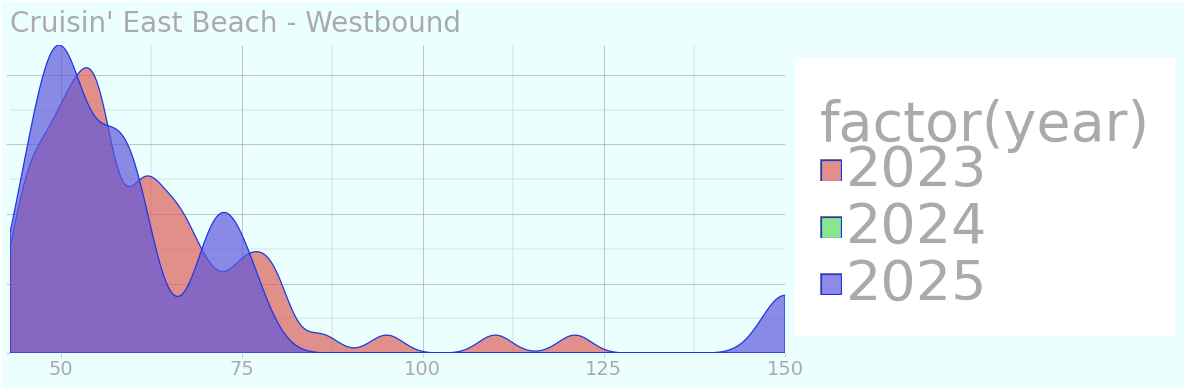

(<ggplot: (820243432)>, 'https://www.strava.com/segments/19129655')

In [29]:
# Selection of segment
activity_date = datetime.date(2025, 5, 4)
segment_index = 12
segment_id = segment_id_from_activity_date_and_index(activities, activity_date, segment_index)
# segment_id = segment_link_to_segment_id('https://www.strava.com/segments/23981846?filter=overall')

segment_effort_graph_distribution(bc_segments, segment_id)

# Segment Highlight
I think it would be real neat to go through each segment of a ride, find ones of note, and display or list them somehow.

- Segments where I've gained local legend
- Segments where I've set a pr
- Segments where my most recent time is much faster than my average.  Percentage or actual seconds.
- Segments wher by recent average is much better than my total average.